In [1]:
import os
import pickle
import argparse
import urllib.request
from pathlib import Path
from PIL import Image

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import numpy as np

from oemer import MODULE_PATH
from oemer import layers
from oemer.inference import inference
from oemer.utils import get_logger
from oemer.dewarp import estimate_coords, dewarp
from oemer.staffline_extraction import extract as staff_extract
from oemer.notehead_extraction import extract as note_extract
from oemer.note_group_extraction import extract as group_extract
from oemer.symbol_extraction import extract as symbol_extract
from oemer.rhythm_extraction import extract as rhythm_extract
from oemer.build_system import MusicXMLBuilder
from oemer.draw_teaser import teaser


logger = get_logger(__name__)

In [2]:
def generate_pred(img_path, use_tf=False):
    logger.info("Extracting staffline and symbols")
    # 악보의 줄과 기호 추출 작업 시작
    staff_symbols_map, _ = inference(
        os.path.join(MODULE_PATH, "checkpoints/unet_big"), # unet_big 모델 경로
        img_path, # 이미지 경로
        use_tf=use_tf,
    )
    
    staff = np.where(staff_symbols_map==1, 1, 0) # 값이 1인 픽셀은 악보의 줄로 표시
    symbols = np.where(staff_symbols_map==2, 1, 0) # 값이 2인 픽셀은 기호로 표시

    logger.info("Extracting layers of different symbols")
    # 다른 기호들의 레이어 추출 작업 시작
    symbol_thresholds = [0.5, 0.4, 0.4] # 기호를 추출하기 위한 임계값의 리스트
    sep, _ = inference(
        os.path.join(MODULE_PATH, "checkpoints/seg_net"), # seg_net 모델 경로
        img_path, # 이미지 경로
        manual_th=None,
        use_tf=use_tf,
    )
    stems_rests = np.where(sep==1, 1, 0) # 값이 1인 픽셀은 기둥과 쉼표로 표시
    notehead = np.where(sep==2, 1, 0) # 값이 2인 픽셀은 음표 머리로 표시
    clefs_keys = np.where(sep==3, 1, 0) # 값이 3인 픽셀은 음자리표로 표시

    return staff, symbols, stems_rests, notehead, clefs_keys

In [3]:
# 이미지 경로 지정
img_path = 'C:/Users/Minjoo Lee/MelodyDots/oemer/ds2_dense/images/2-2C Trombone King 0001.jpg'

In [4]:
# 함수 호출
staff, symbols, stems_rests, notehead, clefs_keys = generate_pred(img_path, use_tf=False)

2023-08-07 15:47:39 Extracting staffline and symbols
C:\Users\Minjoo Lee\.conda\envs\oemer\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CoreMLExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(
C:\Users\Minjoo Lee\.conda\envs\oemer\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


1612 2280


2023-08-07 15:48:59 Extracting layers of different symbols


1612 2280


In [5]:
# from PIL import Image, ImageDraw, ImageFont

# # Classmap 데이터
# classmap_data = {
#     "Classname1": "Description of Classname1",
#     "Classname2": "Description of Classname2",
#     "Classname3": "Description of Classname3"
# }

# # 이미지 크기
# image_width = 400
# image_height = 200

# # 배경 이미지 생성
# image = Image.new('RGB', (image_width, image_height), color='white')
# draw = ImageDraw.Draw(image)

# # 폰트 설정
# font = ImageFont.truetype("arial.ttf", 14)

# # 클래스명과 설명을 이미지에 그리기
# y_offset = 10
# for classname, description in classmap_data.items():
#     draw.text((10, y_offset), f"{classname}: {description}", fill='black', font=font)
#     y_offset += 20

# # 이미지 저장
# image.save("classmap_image.png")

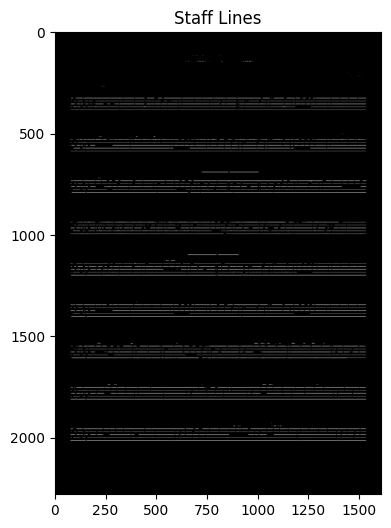

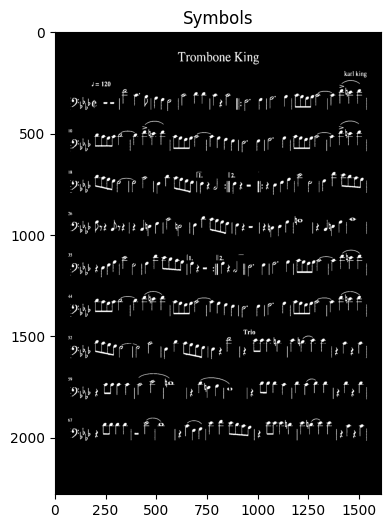

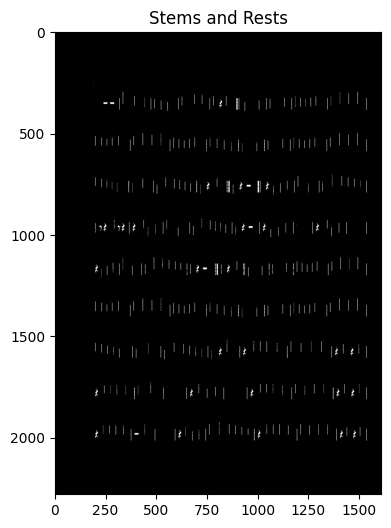

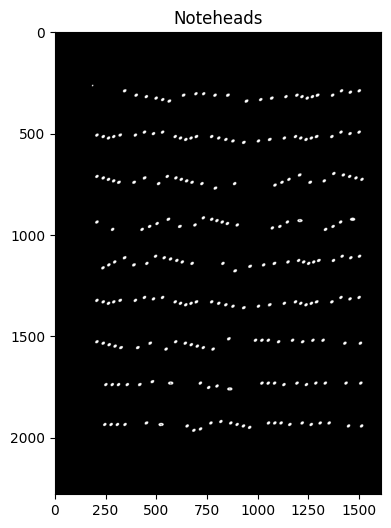

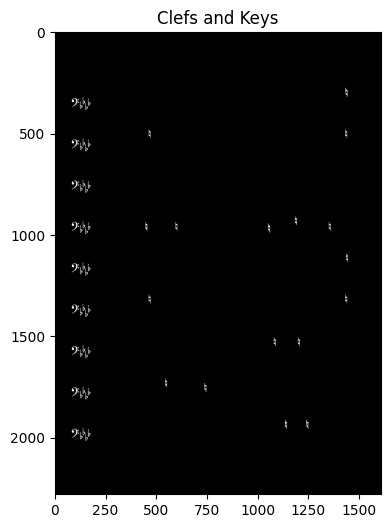

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

plt.imshow(staff, cmap='gray')
plt.title("Staff Lines")
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(symbols, cmap='gray')
plt.title("Symbols")
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(stems_rests, cmap='gray')
plt.title("Stems and Rests")
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(notehead, cmap='gray')
plt.title("Noteheads")
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(clefs_keys, cmap='gray')
plt.title("Clefs and Keys")
plt.show()

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지를 로드합니다. 이때 이미지는 흑백 이미지여야 합니다.
# symbols 변수에 이미지 데이터가 저장되어 있다고 가정합니다.
# symbols = cv2.imread('your_image_path.png', cv2.IMREAD_GRAYSCALE)

# 이미지에서 흑색(0)을 검정색(255)으로, 흰색(255)을 흑색(0)으로 반전시킴
inverted_image = cv2.bitwise_not(symbols)

# 이미지에서 contour를 찾습니다.
contours, _ = cv2.findContours(inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# contour의 크기와 위치를 기준으로 time signature 영역을 추출합니다.
# 예시로 넓이가 특정 값 이상인 contour를 time signature로 가정하겠습니다.
min_area_threshold = 100  # 원하는 최소 contour 넓이를 설정하세요.
time_signature_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area >= min_area_threshold:
        time_signature_contours.append(contour)

# 추출한 contour 영역을 시각화합니다.
output_image = np.copy(symbols)
cv2.drawContours(output_image, time_signature_contours, -1, (0, 0, 0), thickness=cv2.FILLED)

# 이미지를 시각화합니다.
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.imshow(symbols, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap='gray')
plt.title('Time Signature Extraction')
plt.axis('off')

plt.show()

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'
